# Implementation of "A Neural Algorithm of Artistic Style"

This notebook contains the implementation of "A Neural Algorithm of Artistic Style" by Gatys et al. using tensorflow. This notebook is formatted as follow: some explanation then the corresponding lines of code.

### Imports
Below are the libraries we will be using. The tensorflow version used by the time of writing is 1.4.0.

In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

/home/dikatok/miniconda3/envs/deeplearning/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Configuration

Below are the configuration used in this notebook. The vgg16 weights is available for download in [link](http://www.cs.toronto.edu/~frossard/post/vgg16/) (thanks [Davi](https://www.cs.toronto.edu/~frossard/about/) for sharing this) and put it in the project root.

In [2]:
STYLE_IMG = "./images/style.jpg"
CONTENT_IMG = "./images/content.jpg"
RESULT_IMG = "./images/result.jpg"
VGG_WEIGHT = "../vgg16_weights.npz"
LOG_DIR = "./logs"

USE_LOGGING = False
NUM_ITER = 500
LEARNING_RATE = 1
LOG_ITER = 50
SAMPLE_ITER = 50
STYLE_SIZE = 512
CONTENT_SIZE = 512

CONTENT_LOSS_WEIGHT = 1
STYLE_LOSS_WEIGHT = 10000

### Loading the style and content images

We will be using img_to_array and load_img from tf.keras.preprocessing.image to load and convert style and content images to ndarray.

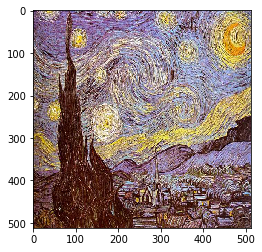

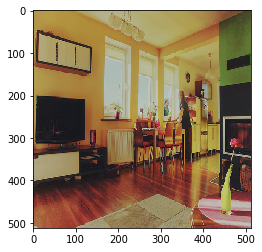

In [3]:
style_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(STYLE_IMG, target_size=(STYLE_SIZE,STYLE_SIZE)))
content_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(CONTENT_IMG, target_size=(CONTENT_SIZE,CONTENT_SIZE)))

plt.imshow(style_image / 255.)
plt.show()
plt.imshow(content_image / 255.)
plt.show()

### VGG16 and loss function

According to the paper, we will be using vgg16 as static loss network to produce the content features (relu3_1) and style features (relu1_1, relu2_1, relu3_1, relu4_1, relu5_1) of (an) images. The loss is calculated bu summing the content (l2 loss between relu3_1 of content and transferred image) and style loss (l2 loss between gram matrices of style and transferred image's style features). Some notes for the implementation:
1. reuse parameter in tf.variable_scope is important if you are going to use the same model multiple times in a single computation graph and sharing the weights, don't forget to use tf.get_variable instead of tf.Variable too to declare the variables used in the model
2. trainable parameter can be used if you don't want the variables to be updated during backward pass
3. we are using avg pool instead of max pool

In [ ]:
def vgg16(x, weights):
    mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='imagenet_mean')
    x = x - mean
    
    with tf.variable_scope("vgg16", reuse=tf.AUTO_REUSE):
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_1_W"]), trainable=False, name='conv1_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_1_b"]), trainable=False, name='conv1_1_b')
            conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_1 = tf.nn.bias_add(conv1_1, biases)
            conv1_1 = tf.nn.relu(conv1_1, name=scope)

        with tf.name_scope('conv1_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_2_W"]), trainable=False, name='conv1_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_2_b"]), trainable=False, name='conv1_2_b')
            conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_2 = tf.nn.bias_add(conv1_2, biases)
            conv1_2 = tf.nn.relu(conv1_2, name=scope)

        pool1 = tf.nn.avg_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
                               name='pool1')

        with tf.name_scope('conv2_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_1_W"]), trainable=False, name='conv2_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_1_b"]), trainable=False, name='conv2_1_b')
            conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_1 = tf.nn.bias_add(conv2_1, biases)
            conv2_1 = tf.nn.relu(conv2_1, name=scope)

        with tf.name_scope('conv2_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_2_W"]), trainable=False, name='conv2_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_2_b"]), trainable=False, name='conv2_2_b')
            conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_2 = tf.nn.bias_add(conv2_2, biases)
            conv2_2 = tf.nn.relu(conv2_2, name=scope)

        pool2 = tf.nn.avg_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool2')

        with tf.name_scope('conv3_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_1_W"]), trainable=False, name='conv3_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_1_b"]), trainable=False, name='conv3_1_b')
            conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_1 = tf.nn.bias_add(conv3_1, biases)
            conv3_1 = tf.nn.relu(conv3_1, name=scope)

        with tf.name_scope('conv3_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_2_W"]), trainable=False, name='conv3_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_2_b"]), trainable=False, name='conv3_2_b')
            conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_2 = tf.nn.bias_add(conv3_2, biases)
            conv3_2 = tf.nn.relu(conv3_2, name=scope)

        with tf.name_scope('conv3_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_3_W"]), trainable=False, name='conv3_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_3_b"]), trainable=False, name='conv3_3_b')
            conv3_3 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_3 = tf.nn.bias_add(conv3_3, biases)
            conv3_3 = tf.nn.relu(conv3_3, name=scope)

        pool3 = tf.nn.avg_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool3')

        with tf.name_scope('conv4_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_1_W"]), trainable=False, name='conv4_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_1_b"]), trainable=False, name='conv4_1_b')
            conv4_1 = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_1 = tf.nn.bias_add(conv4_1, biases)
            conv4_1 = tf.nn.relu(conv4_1, name=scope)

        with tf.name_scope('conv4_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_2_W"]), trainable=False, name='conv4_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_2_b"]), trainable=False, name='conv4_2_b')
            conv4_2 = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_2 = tf.nn.bias_add(conv4_2, biases)
            conv4_2 = tf.nn.relu(conv4_2, name=scope)

        with tf.name_scope('conv4_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_3_W"]), trainable=False, name='conv4_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_3_b"]), trainable=False, name='conv4_3_b')
            conv4_3 = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_3 = tf.nn.bias_add(conv4_3, biases)
            conv4_3 = tf.nn.relu(conv4_3, name=scope)
        
        pool4 = tf.nn.avg_pool(conv4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool4')
            
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv5_1_W"]), trainable=False, name='conv5_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv5_1_b"]), trainable=False, name='conv5_1_b')
            conv5_1 = tf.nn.conv2d(pool4, kernel, [1, 1, 1, 1], padding='SAME')
            conv5_1 = tf.nn.bias_add(conv5_1, biases)
            conv5_1 = tf.nn.relu(conv5_1, name=scope)
            
    return conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

def gram_matrix(x):
    shape = x.shape.as_list()
    x = tf.reshape(x, [shape[0], shape[1] * shape[2], shape[3]])
    return tf.matmul(x, x, transpose_a=True) / (shape[1] * shape[2])

def loss_fun(target_style_features, target_content_features, transferred_features, 
             style_loss_weight=STYLE_LOSS_WEIGHT, content_loss_weight=CONTENT_LOSS_WEIGHT):
    content_loss = tf.nn.l2_loss(target_content_features[2] - transferred_features[2])
    
    style_loss = 0
    for i in range(len(transferred_features)):
        gram_target = gram_matrix(target_style_features[i])
        gram_transferred = gram_matrix(transferred_features[i])
        style_loss = style_loss + tf.nn.l2_loss(gram_target - gram_transferred)
        
    return content_loss_weight * content_loss + style_loss_weight * style_loss

### Optimization

Next, we will begin the optimization, first we will load the vgg model and it's weights then use Adam as optimizer. You can use tensorboard to visualize the loss and sample by turning USE_LOGGING to True.

In [ ]:
vgg_weights = np.load(VGG_WEIGHT)

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Graph().as_default() as g, tf.Session(config=config) as sess:
    s = sess.run(tf.expand_dims(style_image, axis=0))
    c = sess.run(tf.expand_dims(content_image, axis=0))

    style = tf.placeholder(name="style", dtype=tf.float32, shape=[1,STYLE_SIZE,STYLE_SIZE,3])
    content = tf.placeholder(name="content", dtype=tf.float32, shape=[1,CONTENT_SIZE,CONTENT_SIZE,3])
    transferred = tf.clip_by_value(tf.Variable(initial_value=c, dtype=tf.float32), 0, 255)
    
    target_style_features = vgg16(style, vgg_weights)

    target_content_features = vgg16(content, vgg_weights)

    transferred_features = vgg16(transferred, vgg_weights)

    loss = loss_fun(target_style_features, target_content_features, transferred_features)
        
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
    
    style_summary = tf.summary.image("style", style)
    content_summary = tf.summary.image("content", content)
    transferred_summary = tf.summary.image("transferred", transferred)
    loss_summary = tf.summary.scalar("loss", loss)
    
    if USE_LOGGING:
        summary = tf.summary.FileWriter(graph=g, logdir=LOG_DIR)
        cur_style_summary, cur_content_summary = sess.run([style_summary, content_summary], 
                                                          feed_dict={style: s, content: c})
        summary.add_summary(cur_style_summary, 0)
        summary.add_summary(cur_content_summary, 0)
        summary.flush()

    sess.run(tf.global_variables_initializer())
    
    start = time.time()
    for i in range(NUM_ITER):
        it = i + 1
        if it % LOG_ITER == 0:
            cur_loss_summary, cur_loss = sess.run((loss_summary, loss), feed_dict={style: s, content: c})
            if USE_LOGGING: summary.add_summary(cur_loss_summary, it)
            print("Iteration:", it, "loss:", cur_loss)

        sess.run(train_op, feed_dict={style: s, content: c})

        if it % SAMPLE_ITER == 0 and USE_LOGGING:
            cur_transferred_summary = sess.run(transferred_summary, feed_dict={style: s, content: c})
            summary.add_summary(cur_transferred_summary, it)

        if USE_LOGGING: summary.flush()
    end = time.time()
    result = sess.run(tf.squeeze(transferred))

Iteration: 50 loss: 1.70286e+16
Iteration: 100 loss: 5.22551e+15
Iteration: 150 loss: 2.69625e+15
Iteration: 200 loss: 1.71262e+15
Iteration: 250 loss: 1.21982e+15
Iteration: 300 loss: 9.32904e+14


### Show the result

In [ ]:
print("Finished {num_iter} iteration in {time} seconds".format(num_iter=NUM_ITER, time=end-start))
plt.imshow(result / 255.)    
plt.show()

In [ ]:
result_image = tf.keras.preprocessing.image.array_to_img(result)
result_image.save(RESULT_IMG)